<a href="https://colab.research.google.com/github/Rtniewi/advanced-data-ADVDS/blob/main/HW4/ADS_project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

//***Katrina Cwiertniewicz
//*** CSC 792
//11/30/2025
//Project 4
####The purpose of this assignment is to perform experiments on the Customer Satisfaction dataset using SVC and Decision Tree Classifier Models.

### **Import Dependencies**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import graphviz
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import export_text, export_graphviz

### **Load the Dataset**

In [ ]:
# The Customer Segmentation Classification dataset includes 8,052 customers
# and 10 features that will help classfiy each new customer.

# Download latest version
path = kagglehub.dataset_download("kaushiksuresh147/customer-segmentation")

print("Path to dataset files:", path)

100%|██████████| 99.9k/99.9k [00:00<00:00, 288kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kaushiksuresh147/customer-segmentation/versions/31


In [ ]:
# Read the Training Dataset

customers = pd.read_csv(path + "/Train.csv")

customers.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [ ]:
#Train Dataset

np.random.seed(42)

# Create X and y for the training dataset and identify Segmentation as the target
X = customers.drop(['Segmentation'], axis=1)
# Segmentation is a letter label, so it needs to be assigned a numerical value for calculations using mapping
y = customers['Segmentation'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3})

# Drop non-essential columns: ID, Profession, Work_Experience, Var_1
# I dropped these columns as ID was not related to trends with customers. Profession had many different categories that I didn't
# think were strong in comparison to other features. Work Experience and Var_1 were vague features that I think we would have trouble seeing trends from.
X.drop(['ID', 'Profession', 'Work_Experience', 'Var_1'], axis=1, inplace=True )

# use the 80-20 rule for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [ ]:
# Let's examine the dataset features

X.head()

,Gender,Ever_Married,Age,Graduated,Spending_Score,Family_Size
0,Male,No,22,No,Low,4.0
1,Female,Yes,38,Yes,Average,3.0
2,Female,Yes,67,Yes,Low,1.0
3,Male,Yes,67,Yes,High,2.0
4,Female,Yes,40,Yes,High,6.0


## **1) Perform a preliminary analysis on the dataset to determine which attributes have the highest correlation with the target variable. Use graphs to visualize the results.**

In [ ]:
# there were only 2 numerical features so I wanted to include some of the categorical features.
# Reference code for categorical/codes:
# https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html
# https://sqlpey.com/python/top-2-methods-to-convert-categorical-variables-to-numbers-in-pandas/#google_vignette

X_temp = X_train.copy()

for col in X_temp.select_dtypes(include=['object']).columns:
    X_temp[col] = pd.Categorical(X_temp[col]).codes

print(X_temp)

      Gender  Ever_Married  Age  Graduated  Spending_Score  Family_Size
917        0             0   32          1               2          1.0
3398       1             1   72          1               0          2.0
2045       0             0   33          1               2          4.0
8060       0             1   48          1               0          6.0
4604       0             1   28          0               2          1.0
...      ...           ...  ...        ...             ...          ...
3822       0             0   27          0               2          1.0
5864       1             0   37          1               2          2.0
3589       0             0   27          0               2          6.0
1489       1             0   26          0               2          2.0
2661       0             0   37          1               2          3.0

[6454 rows x 6 columns]


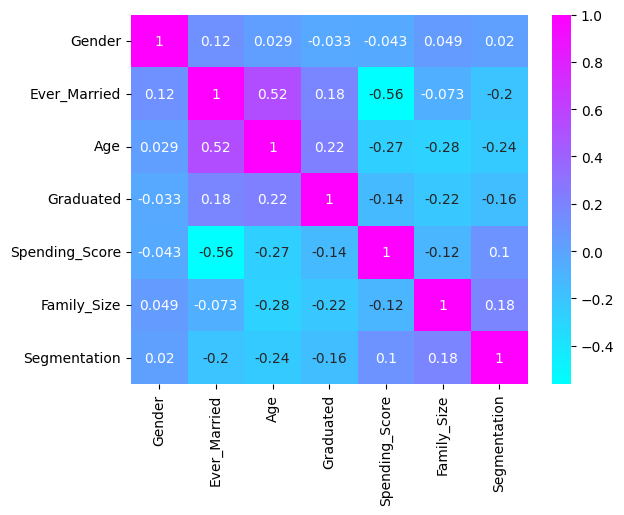

In [ ]:
# produce a heatmap of feature correlations
X_comb = pd.concat([X_temp, y_train.astype(float)], axis=1)
g = sns.heatmap(X_comb[['Gender','Ever_Married','Age','Graduated','Spending_Score','Family_Size','Segmentation']].corr(),
                annot=True,
                cmap = "cool")


### **Correlation Analysis**

The weakest features in order from most to least when compared with the classes are: Age(-0.24), Ever_Married(-0.20), and Graduated(-0.16). The Age feature could be improved by creating Age ranges, as the classes may not be able to find a trend with independent ages.

The highest correlation when compared to classes is Family_Size. If the categories are related to the amount of purchases a customer is making, this would make sense that a larger family would be purchasing more.

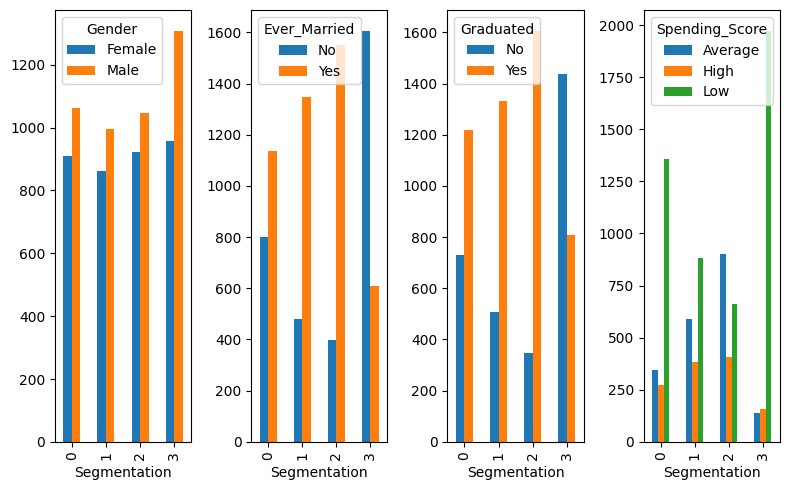

In [ ]:
# let's cross tabulate and compute impact of Gender, Ever_Married, Graduated, and Spending Score on
# the target variable. I chose a few different features to compare trends with the dataset.
figure, axes = plt.subplots(1, 4)

# impact of gender
ct1 = pd.crosstab(y[:], X['Gender'])
ct1.plot.bar(ax = axes[0],figsize=(8,5))

# impact of Ever_Married
ct2 = pd.crosstab(y[:], X['Ever_Married'])
ct2.plot.bar(ax = axes[1], figsize=(8,5))

# impact of Graduated
ct3 = pd.crosstab(y[:], X['Graduated'])
ct3.plot.bar(ax = axes[2], figsize=(8,5))

# impact of Spending Score
ct4 = pd.crosstab(y[:], X['Spending_Score'])
ct4.plot.bar(ax = axes[3], figsize=(8,5))

plt.tight_layout()
plt.show()

## **Preliminary Analysis**

Gender
* Class D has many more males when compared with the rest of the classes. Females have a similar amount in each class. Classes B and D have the biggest gap for females around 100 fewer female customers than in D.


Ever Married
* Class C has the highest number of people who have been married before. Class D has the highest proportion of people who have never been married. From Class A to C, the number of people who have been married before increases as the number who have never been married decreases.


Graduated
* If Ever Married and Graduated are compared, they have almost identical charts for classes A to C. As the number of people who have graduated increases, the number of people who haven't decreases. However, Class D is slightly different from Ever Married. Class D still has more No than YES, but it's not the overall highest value. Class C's YES category is the highest, and the same amount as the Ever Married category for Class D's NO category.


Spending Score
* The Spending Scores from Classes A-C increase for both the Average and High Spending scores. For Classes A-C, both Ever Married and Graduated increase as the Low Spending Score decreases. Class D has the lowest Spending Score customers and the smallest number of customers who have a Spending Score of Average or High.

**Summary**
* If we combined these results, we would see some trends in the data. If Class D were the first class, we would see a consistent positive and negative slope as one increases, the others decrease. Gender is the only category we don't see this in. Gender is emphasized for the Class D's Male category as an outlier value compared to the other values. If we were to sample a customer from Class D, we would most likely find a Customer who is Male, who was never married, who has not graduated, and has a spending score of Low. This could make sense as this customer may only buy for themself and if they haven't graduated may also earn less, which could result in a Low Spending Score.

## **2) Create pipelines to handle missing data values, scaling issues, and encoding (imputers, scalers, encoders for categoric features) as necessary.**

In [ ]:
# Check to see if there are any missing values

X.isnull().sum()

,0
Gender,0
Ever_Married,140
Age,0
Graduated,78
Spending_Score,0
Family_Size,335


There are many missing values in this Dataset.
These features are:
* Ever_Married
* Graduated
* Family_Size

### Imputation will be used to handle missing values

In [ ]:
# Determine which features are catergoric or numerical
X.dtypes

,0
Gender,object
Ever_Married,object
Age,int64
Graduated,object
Spending_Score,object
Family_Size,float64


### **Create Pipelines**

In [ ]:
########## First create a pipeline for the categoric attributes

cat_cols = ['Gender','Ever_Married','Graduated','Spending_Score']

cat_transformer = Pipeline(steps=[
    # strategies are mean, median, most_frequent, etc.
    ('imputer', SimpleImputer(strategy='most_frequent')),

    # In ordinal encoding, each unique category value is assigned an integer value.
    ('ordinal', OrdinalEncoder())
])



########## Second create a pipeline for the numeric attributes

num_cols = ['Age', 'Family_Size']

num_transformer = Pipeline(steps=[
    # Number of neighboring samples to use for K-nearest neighor imputation
    ('imputer', KNNImputer(n_neighbors=5)),

    # StandardScaler makes mean = 0 and scales the data to unit variance
    ('scaler', StandardScaler())
])



########## Finally, apply column transformations

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

## **3) Create pipelines to obtain classification accuracy measures for SVC (linear, poly, RBF) and DecisionTreeClassifier (gini, entropy) models. Keep in mind that the problem here involves multiclass classification.**

In [ ]:
num_folds = 10

# SVC (linear, poly, RBF)

########## A linear kernel classifier
lin_svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='linear'))])

lin_svc_clf_score = cross_val_score(lin_svc_clf, X, y, cv=num_folds, scoring="accuracy").mean()

########## An RBF kernel classifier
rbf_svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='rbf'))])

rbf_svc_clf_score = cross_val_score(rbf_svc_clf, X, y, cv=num_folds, scoring="accuracy").mean()


########## A poly kernel classifier
poly_svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='poly'))])

poly_svc_clf_score = cross_val_score(poly_svc_clf, X, y, cv=num_folds, scoring="accuracy").mean()


# Decission Tree Classifier(gini, entropy)

########## A decicion tree with gini
gini_dt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(criterion='gini'))])

gini_dt_score = cross_val_score(gini_dt_clf, X, y, cv=num_folds, scoring="accuracy").mean()


########## A decicion tree with entropy
entropy_dt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(criterion='entropy'))])

entropy_dt_score = cross_val_score(entropy_dt_clf, X, y, cv=num_folds, scoring="accuracy").mean()





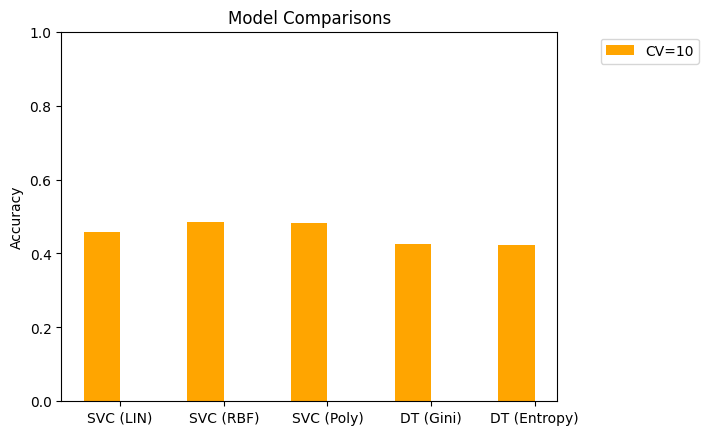

In [ ]:
# Summarize the findings for all models

labels = ['SVC (LIN)', 'SVC (RBF)', 'SVC (Poly)','DT (Gini)', 'DT (Entropy)']
training_scores = [lin_svc_clf_score, rbf_svc_clf_score, poly_svc_clf_score, gini_dt_score, entropy_dt_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_scores, width, label='CV=10', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

plt.title('Model Comparisons')
plt.show()

When comparing all the models, they are not performing very well with the data even though multiclass classification will have lower accuracy than binary classification. Optimization will need to be done to determine which model has the highest accuracy.

## **4) Display the classification knowledge discovered by a decision tree classifier (gini or entropy)**

|--- Gender <= -0.57
|   |--- Gender <= -1.16
|   |   |--- Family_Size <= 1.50
|   |   |   |--- truncated branch of depth 9
|   |   |--- Family_Size >  1.50
|   |   |   |--- truncated branch of depth 12
|   |--- Gender >  -1.16
|   |   |--- Ever_Married <= -0.37
|   |   |   |--- truncated branch of depth 12
|   |   |--- Ever_Married >  -0.37
|   |   |   |--- truncated branch of depth 15
|--- Gender >  -0.57
|   |--- Family_Size <= 1.50
|   |   |--- Spending_Score <= 0.50
|   |   |   |--- truncated branch of depth 19
|   |   |--- Spending_Score >  0.50
|   |   |   |--- truncated branch of depth 27
|   |--- Family_Size >  1.50
|   |   |--- Spending_Score <= 0.50
|   |   |   |--- truncated branch of depth 15
|   |   |--- Spending_Score >  0.50
|   |   |   |--- truncated branch of depth 26



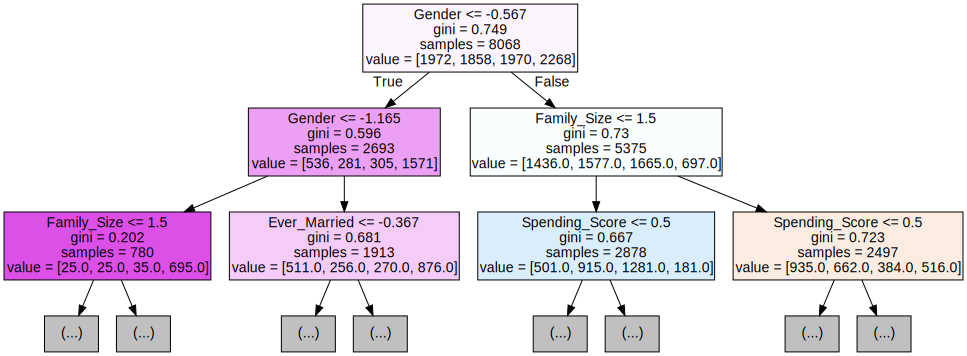

In [ ]:
# Convert the decision tree model to text and graph

# we need to refit the DT model that is part of a composite pipe before exporting it as text
gini_dt_clf['classifier'].fit(preprocessor.fit_transform(X), y)


# display the induced decision tree as a series of logical rules
text_representation = export_text(gini_dt_clf['classifier'],
                                  feature_names=['Gender','Ever_Married', 'Age', 'Graduated', 'Spending_Score', 'Family_Size'],
                                  max_depth=2)
print(text_representation)


# draw the induced decision tree
dot_data = export_graphviz(gini_dt_clf['classifier'],
                                  max_depth=2,
                                  feature_names=['Gender','Ever_Married', 'Age', 'Graduated', 'Spending_Score', 'Family_Size'],
                                  filled=True)

graph = graphviz.Source(dot_data, format="png")
graph

Feature: 0, Score: 0.56058
Feature: 1, Score: 0.17558
Feature: 2, Score: 0.06374
Feature: 3, Score: 0.02952
Feature: 4, Score: 0.05937
Feature: 5, Score: 0.11120


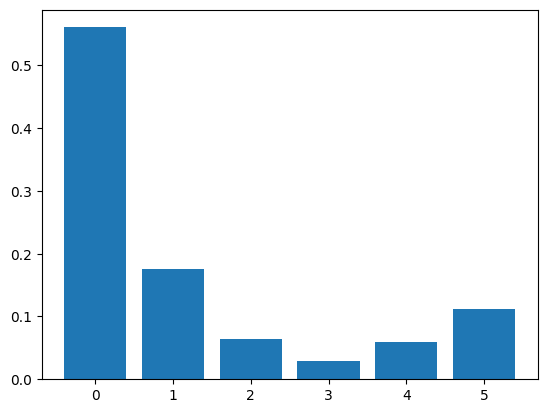

In [ ]:
# get feature importances from the model
importance = gini_dt_clf['classifier'].feature_importances_

# summarize feature importances
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importances
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### **Feature Analysis of the Decision Tree Classifier(gini)**

* Gender: 56%
* Ever Married: 18%
* Age: 6%
* Graduated: 3%
* Spending Score: 4%
* Family Size: 11%

**Summary**

Gender had the highest importance and was the first split for the decision tree classifier at a 56% split. This would make sense as the Decision Tree would want to choose a feature that equally splits the data the most. Graduated had the lowest importance with a 3% split. Graduated may be dropped for future tests because it is not contributing much to finding a distinction between groups.


## **5) Plot the obtained accuracy values for each model before and after hyperparameter parameters of your choice have been optimized using GridSearchCV.**

### **Decision Tree Classifier (Gini)**

In [ ]:
# Use GridSearchCV to find optimum hyperparameter values for the DT model (gini)


# create a dictionary of all values we want to test
param_grid1 = { 'criterion':['gini'],    # impurity criterion
              'max_depth': np.arange(3, 15)}      # tree depth


# use gridsearch to test all values
grid_search1 = GridSearchCV(entropy_dt_clf['classifier'],
                           param_grid1,
                           cv=3)

# fit the model
grid_search1.fit(preprocessor.fit_transform(X_train), y_train)


print("The best achieved accuracy after hyperparameter optimization: %.2f \n" % (grid_search1.best_score_))

print("The best DT model hyperparameters:", grid_search1.best_params_)


The best achieved accuracy after hyperparameter optimization: 0.49 

The best DT model hyperparameters: {'criterion': 'gini', 'max_depth': np.int64(4)}


### **Decision Tree Classifier (Entropy)**

In [ ]:
# Use GridSearchCV to find optimum hyperparameter values for the DT model (entropy)


# create a dictionary of all values we want to test
param_grid2 = { 'criterion':['entropy'],    # impurity criterion
              'max_depth': np.arange(3, 15)}      # tree depth


# use gridsearch to test all values
grid_search2 = GridSearchCV(entropy_dt_clf['classifier'],
                           param_grid2,
                           cv=3)

# fit the model
grid_search2.fit(preprocessor.fit_transform(X_train), y_train)


print("The best achieved accuracy after hyperparameter optimization: %.2f \n" % (grid_search2.best_score_))

print("The best DT model hyperparameters:", grid_search2.best_params_)

The best achieved accuracy after hyperparameter optimization: 0.49 

The best DT model hyperparameters: {'criterion': 'entropy', 'max_depth': np.int64(4)}


### **SVC (Linear)**

In [ ]:
# Use GridSearchCV to find optimum hyperparameter values for the SVC Linear model


# create a dictionary of all values we want to test
param_grid3 = {'kernel':['linear'],            # Kernel coefficient for 'linear'.
              'gamma':['scale','auto'],
              'degree': np.arange(4,8),      # polynomial degree
              'C': np.arange(1,10)}          # Regularization parameter


# use gridsearch to test all values
grid_search3 = GridSearchCV(lin_svc_clf['classifier'],
                           param_grid3,
                           cv=3)

# fit the model
grid_search3.fit(preprocessor.fit_transform(X_train), y_train)


print("The best achieved accuracy after hyperparameter optimization: %.2f\n" % grid_search3.best_score_)

print("The best SVC linear model hyperparameters:", grid_search3.best_params_)


The best achieved accuracy after hyperparameter optimization: 0.46

The best SVC linear model hyperparameters: {'C': np.int64(9), 'degree': np.int64(4), 'gamma': 'scale', 'kernel': 'linear'}


### **SVC (RBF)**

In [ ]:
# Use GridSearchCV to find optimum hyperparameter values for the SVC RBF model


# create a dictionary of all values we want to test
param_grid4 = {'kernel':['rbf'],            # Kernel coefficient for ‘rbf’
              'gamma':['scale','auto'],
              'degree': np.arange(4,8),      # polynomial degree
              'C': np.arange(1,10)}          # Regularization parameter


# use gridsearch to test all values
grid_search4 = GridSearchCV(rbf_svc_clf['classifier'],
                           param_grid4,
                           cv=3)

# fit the model
grid_search4.fit(preprocessor.fit_transform(X_train), y_train)


print("The best achieved accuracy after hyperparameter optimization: %.2f\n" % grid_search4.best_score_)

print("The best SVC poly model hyperparameters:", grid_search4.best_params_)

The best achieved accuracy after hyperparameter optimization: 0.48

The best SVC poly model hyperparameters: {'C': np.int64(1), 'degree': np.int64(4), 'gamma': 'scale', 'kernel': 'rbf'}


### **SVC (Poly)**

In [ ]:
# Use GridSearchCV to find optimum hyperparameter values for the SVC Polynomial model

# create a dictionary of all values we want to test
param_grid5 = {'kernel':['poly'],            # Kernel coefficient for 'poly’.
              'gamma':['scale','auto'],
              'degree': np.arange(4,8),      # polynomial degree
              'C': np.arange(1,10)}          # Regularization parameter


# use gridsearch to test all values
grid_search5 = GridSearchCV(poly_svc_clf['classifier'],
                           param_grid5,
                           cv=3)

# fit the model
grid_search5.fit(preprocessor.fit_transform(X_train), y_train)


print("The best achieved accuracy after hyperparameter optimization: %.2f\n" % grid_search5.best_score_)

print("The best SVC poly model hyperparameters:", grid_search5.best_params_)

The best achieved accuracy after hyperparameter optimization: 0.48

The best SVC poly model hyperparameters: {'C': np.int64(6), 'degree': np.int64(4), 'gamma': 'scale', 'kernel': 'poly'}


## **Models before and after hyperparameter parameters have been optimized using GridSearchCV**

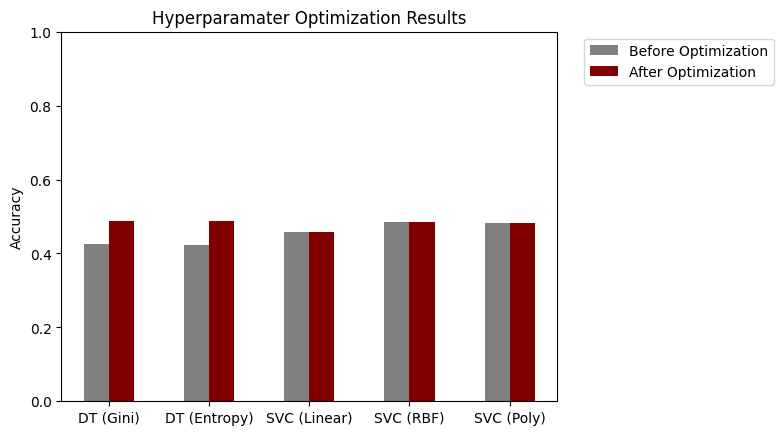

In [ ]:
# graph results of grid search for the five models

labels = labels = ['DT (Gini)','DT (Entropy)','SVC (Linear)', 'SVC (RBF)', 'SVC (Poly)',]
before_optimization_scores = [ gini_dt_score, entropy_dt_score, lin_svc_clf_score, rbf_svc_clf_score, poly_svc_clf_score,]
after_optimization_scores = [grid_search1.best_score_, grid_search2.best_score_, grid_search3.best_score_, grid_search4.best_score_, grid_search5.best_score_]

x = np.arange(len(labels))  # the label locations
width = 0.25                # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before_optimization_scores, width, label='Before Optimization', color='gray')
rects2 = ax.bar(x + width/2, after_optimization_scores, width, label='After Optimization', color='maroon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1.0)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.45, 1.0), loc='upper right')

plt.title('Hyperparamater Optimization Results')
plt.show()

## **6)  Summarize your findings.**

Decision Tree Classifier(gini)
* Accuracy: 49%
* Max Depth: 4

Decision Tree Classifier(entropy)
* Accuracy: 49%
* Max Depth: 4

SVC(linear)
* Accuracy: 46%
* C: 9
* Degree: 4

SVC(RBF)
* Accuracy: 48%
* C: 1
* Degree: 4

SVC(poly)
* Accuracy: 48%
* C: 6
* Degree: 4

The Decision Tree Classifiers performed the best at 49% accuracy. Both criteria (Gini, Entropy) resulted in the same depth and accuracy. This makes sense as they should split the values similarly. The main difference would have been different values for each criterion split, and the speed of training with entropy would have been slower.

The SVC models all use the same degree of 4 but have varying cost values. SVC(RBF) had the lowest optimal cost of 1, SVC(poly) has an optimal cost of 6, and SVC(linear) had the highest optimal cost of 9. From the accuracy model, it looks like SVC(linear) continues to increase cost, which still resulted in the lowest accuracy of all models. It seems like the model may have trained well, but overfitted due to the smaller margin. Increasing the cost will result in an increased penalty for miscalculations. If comparing only the SVC models, the RBF kernel would be the best choice as the cost is low. This should represent a better generalized model that may have more miscalculations, but shouldn’t be as sensitive to noise in the data.

However, accuracy is not the only value that should identify the best model. Looking at the other scores, such as Recall or Precision, could explain more of the model. This is because multiclass classification models have lower accuracy percentages than binary classification due to more choices.

These models should still be improved, but may only be improved by as much as 20% accuracy. This could be done by reevaluating the preprocessing data. However, this will not be as high as a binary classification, which is usually represented in the high 90s as a fairly accurate model.

Overall, the Decision Tree(Gini/Entropy) was able to split some features well, such as Gender and Ever Married and when optimized, had the highest accuracy score. SVC(RBF) had the best generalized model with a cost of 1, and with the addition of more correlated features, could classify test data well.